state vector dim = 4
n_actions = 2


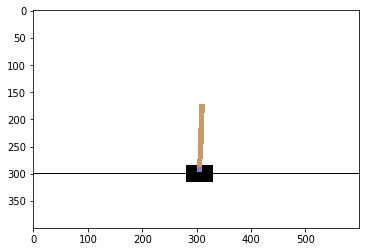

In [2]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import joblib

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


net = torch.nn.Sequential(
    torch.nn.Linear(state_dim, 18),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(18, 18),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(18, n_actions),
    torch.nn.Softmax(dim =1)
)

if torch.cuda.is_available():
    net = net.cuda()
    
for param in list(net.parameters()):
    param.requires_grad = False
print(net)

Sequential(
  (0): Linear(in_features=4, out_features=18, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=18, out_features=18, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=18, out_features=2, bias=True)
  (5): Softmax(dim=1)
)


In [4]:
# s = torch.Tensor(env.reset(),)
# #with torch.no_grad():
# t=net(s.view((1,-1)))
    
# print(t)

In [5]:
# net.state_dict()['0.weight']
# net.state_dict()['0.weight'] += 1
# net.state_dict()
#with torch.no_grad():

In [39]:
def sample_delta(net,seed,sigma):
    np.random.seed(seed)
    
    delta = {}
    for k,v in net.state_dict().items():
        delta[k] = sigma * torch.Tensor(np.random.normal(size=v.size()))
    
    return delta
    

In [27]:
class ESDNNPolicy(torch.nn.Module):
    
    def __init__(self, state_dim, n_actions, hidden_layer_size = [18,18]):
        super(ESDNNPolicy, self).__init__()
        
        layers = [torch.nn.Linear(state_dim, hidden_layer_size[0]),torch.nn.ReLU(inplace=True)]
        for i in range(len(hidden_layer_size)-1):
            
            layers.append(torch.nn.Linear(hidden_layer_size[i], hidden_layer_size[i+1]))
            layers.append(torch.nn.ReLU(inplace=True))
        layers +=    [torch.nn.Linear(hidden_layer_size[-1], n_actions),torch.nn.Softmax(dim =1)]
        
        self.model =  torch.nn.Sequential(*layers)
        
        if torch.cuda.is_available():
            self.model = self.model.cuda()

        for param in list(self.model.parameters()):
            param.requires_grad = False
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def apply_delta(self,delta):
        for k in self.state_dict():
            self.state_dict()[k] += delta[k]
    
    def copy_from(self,other):
        self.load_state_dict(other.state_dict())
        
        

In [10]:
%timeit t = ESDNNPolicy(state_dim,n_actions)

300 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
t = ESDNNPolicy(state_dim,n_actions)
%timeit sample_delta(t,123,1)

218 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
delta = sample_delta(t,123,1)
%timeit t.apply_delta(delta)


165 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
t1 = ESDNNPolicy(state_dim,n_actions)
%timeit t1.copy_from(t)

85.8 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
t = ESDNNPolicy(state_dim,n_actions)
t1 = ESDNNPolicy(state_dim,n_actions)

### Single thread version

In [75]:
def calc_update_vec(policy,rewards,seeds,alpha,sample_num,sigma):
    
    rewards = np.array(rewards)
    rewards = (rewards-np.mean(rewards))/np.std(rewards)
    ans = {}
    for i in range(sample_num):
        delta = sample_delta(policy,seeds[i],sigma)
        for k in delta:
            if k not in ans:
                ans[k]= delta[k]*rewards[i]/sigma
            else:
                ans[k]+= delta[k]*rewards[i]/sigma
    for k in ans:
        ans[k]*=alpha/(sample_num*sigma)
    return ans

In [76]:
def generate_session(env,policy, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        #print(policy(torch.Tensor(s)))
        probs = policy(torch.Tensor(s).view(1,-1)).numpy().reshape(-1)

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        #print(probs)
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions),p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        total_reward += r

        s = new_s
        if done:
            break
    return  total_reward

In [77]:
def calc_reward(policy,env,n_session = 10):
    ans = 0.0
    for _ in range(n_session):
        ans += generate_session(env,policy)
    return ans/n_session

In [54]:
policy = ESDNNPolicy(state_dim,n_actions)
%timeit calc_reward(policy,env)

32.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
from IPython.display import clear_output

def show_progress(rewards, log, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = rewards
    log.append(mean_reward)

    clear_output(True)
    print("iteration =%d  mean reward = %.3f" % (len(log),mean_reward))
    plt.figure(figsize=[8, 4])
    plt.plot(log, label='Mean rewards')
    plt.legend()
    plt.grid()

    plt.show()

iteration =120  mean reward = 1000.000


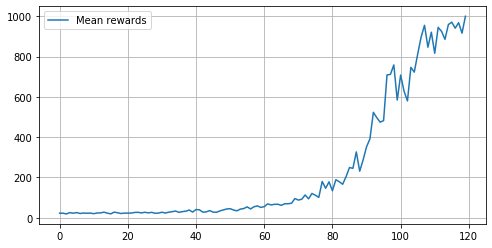

In [83]:
alpha = 0.01
sigma = 0.1
sample_num = 50

policy = ESDNNPolicy(state_dim,n_actions)
log = []

for iteration in range(120):
    rewards = []
    seeds = np.random.randint(low = 0,high = 10**8,size=sample_num)
    for i in range(sample_num):
        delta = sample_delta(policy,seeds[i],sigma)
        new_policy = ESDNNPolicy(state_dim,n_actions)
        new_policy.copy_from(policy)
        new_policy.apply_delta(delta)
        
        rewards.append(calc_reward(new_policy,env))
    update_theta = calc_update_vec(policy,rewards,seeds,alpha,sample_num,sigma)
    policy.apply_delta(update_theta)
    
    r = calc_reward(policy,env,n_session=20)

    show_progress(r,log,reward_range=[0, np.max(r)])
        

### Parallel version

In [88]:
def get_rewards(seed):
    delta = sample_delta(policy,seed,sigma)
    new_env = gym.make("CartPole-v0").env
    new_env.reset()
    new_policy = ESDNNPolicy(state_dim,n_actions)
    new_policy.copy_from(policy)
    new_policy.apply_delta(delta)

    return calc_reward(new_policy,new_env,n_session=5)

In [87]:
%timeit get_rewards(5)

662 ms ± 98.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
from joblib import Parallel, delayed

In [91]:
seeds = np.random.randint(low = 0,high = 10**8,size=sample_num)
#Parallel(n_jobs=4)(delayed(get_rewards)(seed) for seed in seeds)

iteration =120  mean reward = 1000.000


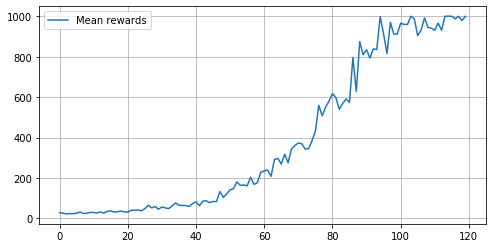

In [92]:
alpha = 0.01
sigma = 0.1
sample_num = 50

policy = ESDNNPolicy(state_dim,n_actions)
log = []

for iteration in range(120):
    
    seeds = np.random.randint(low = 0,high = 10**8,size=sample_num)
    rewards = Parallel(n_jobs=4)(delayed(get_rewards)(seed) for seed in seeds)
    update_theta = calc_update_vec(policy,rewards,seeds,alpha,sample_num,sigma)
    policy.apply_delta(update_theta)
    
    r = calc_reward(policy,env,n_session=20)

    show_progress(r,log,reward_range=[0, np.max(r)])